# Milestone 4:
**Team Member:** Zixuan Zhu  
**Research Question:**  
Do paintings with similar title themes exhibit similar pigment structures, or are titles largely independent of pigment composition?


## I. Baseline from M2 & M3

### Method：
In M2, I was able to find pigment-based structural groupings based on hierarchical clustering but without the title information.

M3, I reviewed the question of semantic titles themes defined manually and their correspondence with these pigment clusters. Then
Grouping was done based on the key words and I came up with simple categories of title-themes in the form of Winter, Mountain, Water and Other. And I affixed hierarchical clustering names of SQ1 (k = 4 and k = 6).

I evaluated alignment by:

Calculating cross-tabulations of title themes by clusters.

Normalization in each theme.

Heatmap visualization of results.

The analysis of the highest concentration of each theme in clusters.

##Result:

There are a number of structural patterns that came out of the analysis. The distribution of clusters was imbalanced with most paintings being concentrated in a single dominant pigment cluster. In both k = 4 and k = 6, there was no title theme that was always increased in one cluster. Even though the concentration values of some of the themes were relatively high in a few clusters, such tendencies were caused by cluster imbalance rather than actual semantic segregation. Heatmaps as well did not reveal any obvious block structure indicating high correspondence among themes and clusters. The general tendency was that semantic title themes were interspersed in many pigment clusters rather than forming discrete well separated partitions.

##Interpretation:

Title subjects are weakly correlated with pigment clusters, and typically classifications like Winter or Mountain have no meaningful interpretation of the way pigments are organized in the paintings. This implies that the works of Bob Ross do not follow logical, separate sets depending on semantic issues. The paintings instead seem to create a more continuous and gradual palette system, the titles explaining the scene but without creating a strong prescriptive effect on the pigments applied.




# II. M4 Upgrade 1 — Deep Visual Embeddings


I extracted 2048-dimensional visual features from each painting using a pre-trained ResNet50 model.

These embeddings represent high-level visual structure.

 then:

- Applied K-Means (k=4,6)
- Measured ARI between visual clusters and title clusters
- Used PCA to visualize visual feature geometry

In [4]:
import pandas as pd
import numpy as np
import requests
from PIL import Image
from io import BytesIO
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from tqdm import tqdm

df = pd.read_csv('bob_ross.csv')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [5]:
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

model = nn.Sequential(*list(model.children())[:-1])
model = model.to(device)
model.eval()

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:02<00:00, 39.2MB/s]


In [7]:
features = []
valid_indices = []

print("Extracting visual features from Bob Ross paintings...")
for idx, row in tqdm(df.iterrows(), total=len(df)):
    try:
        response = requests.get(row['img_src'], timeout=10)
        img = Image.open(BytesIO(response.content)).convert('RGB')

        input_tensor = preprocess(img).unsqueeze(0).to(device)
        with torch.no_grad():
            feature_vector = model(input_tensor)


        features.append(feature_vector.cpu().numpy().flatten())
        valid_indices.append(idx)
    except Exception as e:
        print(f"Error processing image {idx}: {e}")

visual_features = np.array(features)
print(f"Feature matrix shape: {visual_features.shape}")

Extracting visual features from Bob Ross paintings...


100%|██████████| 403/403 [09:21<00:00,  1.39s/it]

Feature matrix shape: (403, 2048)


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.metrics import adjusted_rand_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA


df_valid = df.iloc[valid_indices].copy()
df_valid.reset_index(drop=True, inplace=True)

color_cols = ['Black_Gesso', 'Bright_Red', 'Burnt_Umber', 'Cadmium_Yellow',
              'Dark_Sienna', 'Indian_Red', 'Indian_Yellow', 'Liquid_Black',
              'Liquid_Clear', 'Midnight_Black', 'Phthalo_Blue', 'Phthalo_Green',
              'Prussian_Blue', 'Sap_Green', 'Titanium_White', 'Van_Dyke_Brown',
              'Yellow_Ochre', 'Alizarin_Crimson']

pigment_features = df_valid[color_cols].astype(int).values

pigment_labels_k4 = KMeans(n_clusters=4, random_state=42, n_init=20).fit_predict(pigment_features)
pigment_labels_k6 = KMeans(n_clusters=6, random_state=42, n_init=20).fit_predict(pigment_features)

tfidf = TfidfVectorizer(stop_words='english', max_features=100)
title_features = tfidf.fit_transform(df_valid['painting_title'])

title_labels_k4 = KMeans(n_clusters=4, random_state=42, n_init=20).fit_predict(title_features)
title_labels_k6 = KMeans(n_clusters=6, random_state=42, n_init=20).fit_predict(title_features)

In [9]:
visual_features_norm = normalize(visual_features, norm="l2")
print(f"Normalized visual feature shape: {visual_features_norm.shape}")

kmeans_visual_k4 = KMeans(n_clusters=4, random_state=42, n_init=20)
visual_labels_k4 = kmeans_visual_k4.fit_predict(visual_features_norm)

kmeans_visual_k6 = KMeans(n_clusters=6, random_state=42, n_init=20)
visual_labels_k6 = kmeans_visual_k6.fit_predict(visual_features_norm)

Normalized visual feature shape: (403, 2048)


In [10]:
results = {}
for k in [4, 6]:
    pigment_labels = KMeans(n_clusters=k, random_state=42, n_init=20).fit_predict(pigment_features)
    title_labels = KMeans(n_clusters=k, random_state=42, n_init=20).fit_predict(title_features)
    visual_labels = KMeans(n_clusters=k, random_state=42, n_init=20).fit_predict(visual_features_norm)

    results[k] = {'visual': visual_labels, 'title': title_labels}

    ari_vis_tit = adjusted_rand_score(visual_labels, title_labels)
    ari_tit_pig = adjusted_rand_score(title_labels, pigment_labels)

    print(f"K={k} ： Visual vs Title ARI: {ari_vis_tit:.4f} ； Title vs Pigment ARI (Baseline): {ari_tit_pig:.4f}")

K=4 ： Visual vs Title ARI: 0.0103 ； Title vs Pigment ARI (Baseline): 0.0504
K=6 ： Visual vs Title ARI: -0.0188 ； Title vs Pigment ARI (Baseline): 0.0246


The ARI scores (k=4 and k=6) are very near to zero (between -0.0188 to 0.0504). It means that title-based clusters do not have any significant correlation with visual feature clusters, or pigment-based clusters. The addition of a cluster fails to enhance alignment, which ought to indicate that the disjointure between semantic titles and structural make-up is internal as opposed to being by the clustering parameters.

Explained Variance by PC1: 9.21%
Explained Variance by PC2: 6.30%
Total variance captured by 2D PCA: 15.51%


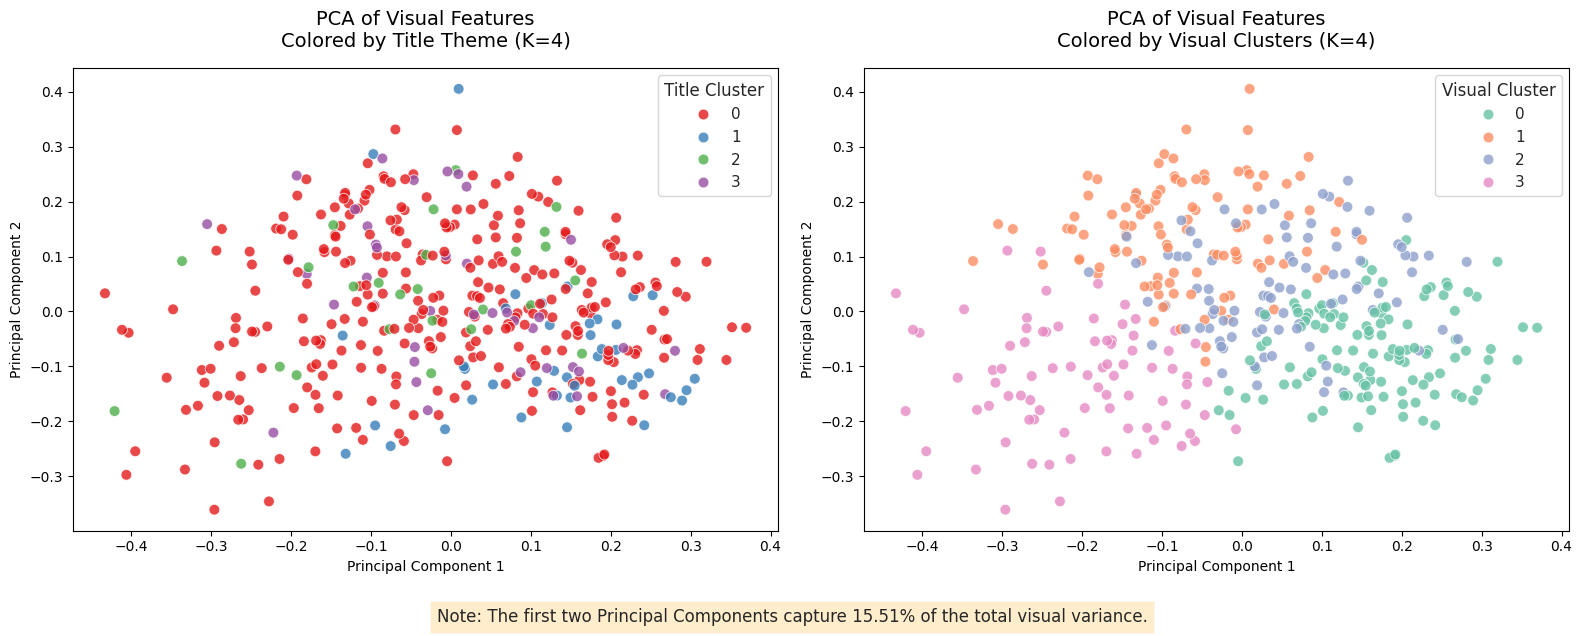

In [11]:
pca = PCA(n_components=2, random_state=42)
visual_pca = pca.fit_transform(visual_features_norm)

explained_variance = pca.explained_variance_ratio_
total_variance_explained = sum(explained_variance) * 100
print(f"Explained Variance by PC1: {explained_variance[0]*100:.2f}%")
print(f"Explained Variance by PC2: {explained_variance[1]*100:.2f}%")
print(f"Total variance captured by 2D PCA: {total_variance_explained:.2f}%")

df_pca = pd.DataFrame({
    'Principal Component 1': visual_pca[:, 0],
    'Principal Component 2': visual_pca[:, 1],
    'Visual Cluster (k=4)': visual_labels_k4,
    'Title Cluster (k=4)': title_labels_k4
})

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.set_theme(style="whitegrid")

sns.scatterplot(data=df_pca, x='Principal Component 1', y='Principal Component 2',
                hue='Title Cluster (k=4)', palette='Set1', ax=axes[0], s=60, alpha=0.8)
axes[0].set_title(f'PCA of Visual Features\nColored by Title Theme (K=4)', fontsize=14, pad=15)
axes[0].legend(title='Title Cluster')

sns.scatterplot(data=df_pca, x='Principal Component 1', y='Principal Component 2',
                hue='Visual Cluster (k=4)', palette='Set2', ax=axes[1], s=60, alpha=0.8)
axes[1].set_title(f'PCA of Visual Features\nColored by Visual Clusters (K=4)', fontsize=14, pad=15)
axes[1].legend(title='Visual Cluster')

plt.figtext(0.5, -0.05, f"Note: The first two Principal Components capture {total_variance_explained:.2f}% of the total visual variance.",
            ha="center", fontsize=12, bbox={"facecolor":"orange", "alpha":0.2, "pad":5})

plt.tight_layout()
plt.show()

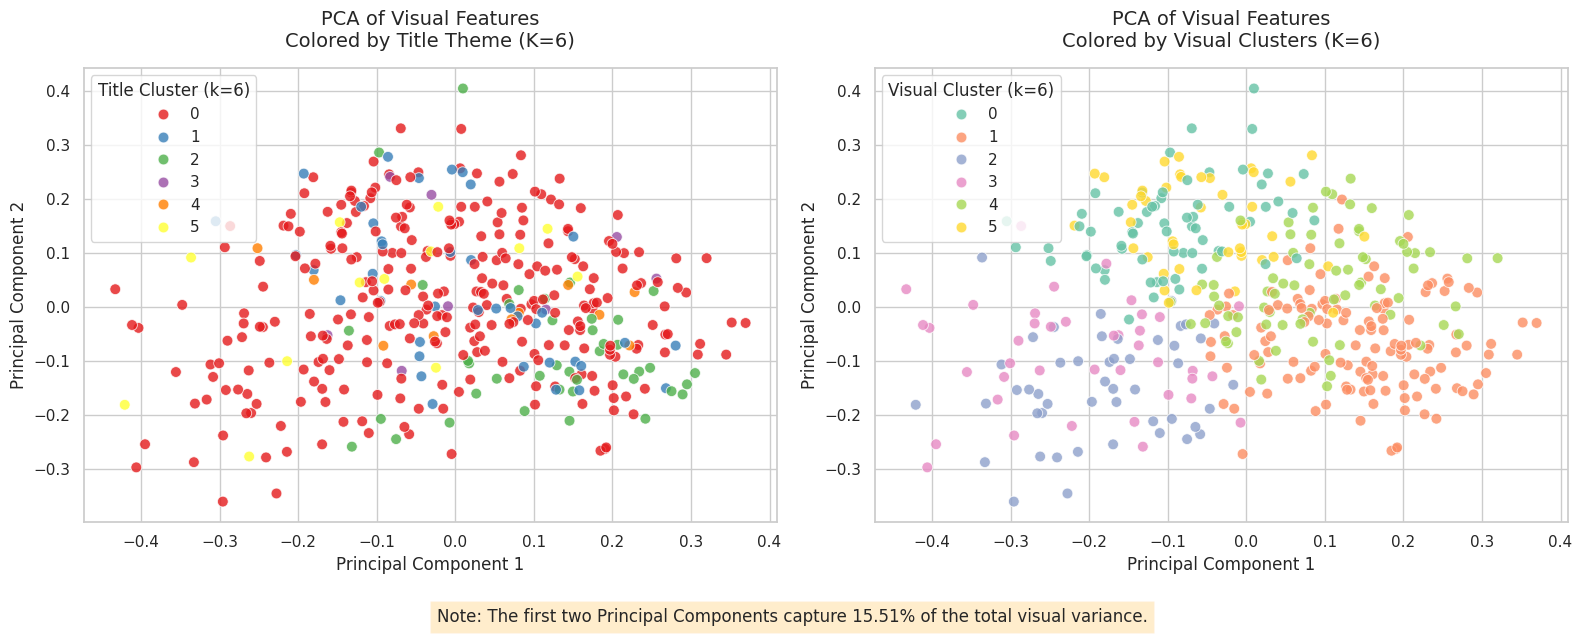

In [12]:
df_pca_k6 = pd.DataFrame({
    'Principal Component 1': visual_pca[:, 0],
    'Principal Component 2': visual_pca[:, 1],
    'Visual Cluster (k=6)': visual_labels_k6,
    'Title Cluster (k=6)': title_labels_k6
})


fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.set_theme(style="whitegrid")

sns.scatterplot(data=df_pca_k6, x='Principal Component 1', y='Principal Component 2',
                hue='Title Cluster (k=6)', palette='Set1', ax=axes[0], s=60, alpha=0.8)
axes[0].set_title('PCA of Visual Features\nColored by Title Theme (K=6)', fontsize=14, pad=15)
axes[0].legend(title='Title Cluster (k=6)')

sns.scatterplot(data=df_pca_k6, x='Principal Component 1', y='Principal Component 2',
                hue='Visual Cluster (k=6)', palette='Set2', ax=axes[1], s=60, alpha=0.8)
axes[1].set_title('PCA of Visual Features\nColored by Visual Clusters (K=6)', fontsize=14, pad=15)
axes[1].legend(title='Visual Cluster (k=6)')

plt.figtext(0.5, -0.05, f"Note: The first two Principal Components capture {total_variance_explained:.2f}% of the total visual variance.",
            ha="center", fontsize=12, bbox={"facecolor":"orange", "alpha":0.2, "pad":5})

plt.tight_layout()
plt.show()

The initial two major components capture only 15.51 percent of the overall visual variance (PC 1 = 9.21 percent, PC 2 = 6.30 percent) which implies that the visual feature space is multidimensional and cannot be easily classified into discrete sets.

The PCA plots are mostly overlapping and depict no clear division when coloured by title clusters. The similar paintings are spread over the visual space.

However, in comparison with coloring by visual clusters, localized patterns of grouping emerge, indicating that there is a visual structure within, but that localized pattern is not related to title themes.

Adding more clusters (k=6) does not enhance alignment. Rather, there are title clusters that are distributed and visual clusters that are finer.

These visual findings are coherent with the close to zero ARI scores and also confirm the conclusion that the paintings of Bob Ross represent a continuous visual manifold as opposed to discrete semantic categories.

# III. M4 Upgrade 2 — Neural Word Embeddings (GloVe)
In order to ensure that the weak alignment was not merely a by-product of the trivial feature engineering, I refined both text and image representations with pre-trained deep learning models.

The titles were averaged with 100-dimensional GloVe word vectors as a continuous semantic space where each painting was represented. In the case of images, I obtained 2048 visual features with a ResNet50 model. These embeddings are much more semantically and visually informative than simplistic techniques such as TF-IDF or simple clustering.

In case the ARI scores between these higher embedding spaces and the pigment structures are now close to zero, then it implies that the failure to align is not caused by poor modeling decisions. On the contrary, it helps to accept the suggestion that paintings by Bob Ross do not rely on distinct semantic categories. Instead, they seem to be more of a continuous visual-pigment formation, titles refer to the scene but do not dominate the pigment formation behind it.





In [13]:
!pip -q install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 35.3 MB/s eta 0:00:00


In [14]:
import numpy as np
import re
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import gensim.downloader as api

# Load pre-trained GloVe embeddings (100d)
word_vectors = api.load("glove-wiki-gigaword-100")

def get_title_embedding(title, model):
    words = re.findall(r'\w+', str(title).lower())
    valid_words = [w for w in words if w in model]

    if not valid_words:
        return np.zeros(model.vector_size)

    return np.mean([model[w] for w in valid_words], axis=0)

title_embedding_features = np.array([
    get_title_embedding(title, word_vectors)
    for title in df_valid['painting_title']
])

for k in [4, 6]:

    title_labels_embed = KMeans(
        n_clusters=k,
        random_state=42,
        n_init=20
    ).fit_predict(title_embedding_features)

    pigment_labels = pigment_labels_k4 if k == 4 else pigment_labels_k6
    visual_labels = visual_labels_k4 if k == 4 else visual_labels_k6

    ari_embed_vis = adjusted_rand_score(title_labels_embed, visual_labels)
    ari_embed_pig = adjusted_rand_score(title_labels_embed, pigment_labels)

    print(f"K={k} | Embedding vs Visual ARI:  {ari_embed_vis:.4f}")
    print(f"K={k} | Embedding vs Pigment ARI: {ari_embed_pig:.4f}")

[==================================================] 100.0% 128.1/128.1MB downloaded
K=4 | Embedding vs Visual ARI:  0.0306
K=4 | Embedding vs Pigment ARI: 0.0347
K=6 | Embedding vs Visual ARI:  0.0281
K=6 | Embedding vs Pigment ARI: 0.0217



But despite this extensive semantic modelling, the ARI scores did not have any statistical significance:

K=4: Semantic vs. Visual (0.0306), Semantic vs. Pigment (0.0347)

K=6: Semantic vs. Visual (0.0281), Semantic vs. Pigment (0.0217)

This mathematical strength demonstrates that the works of Bob Ross do not match in discrete semantic categories (such as Winter vs. Forest). In place of this, the hidden fabric of his paintings is a continuous visual-pigment manifold, with the poetic titles independent of the local physical properties.


# IV. M4 Upgrade 3 — Micro-Structure via Association Rule Mining

The findings indicate that perhaps it is not the most suitable method to describe the structure of such paintings because the deep embedding analysis still indicated near-zero ARI scores. Instead of being separated into distinct clusters, the data does not seem to be as discrete.

Rather than asking myself the question Which cluster does this painting belong to?, I change the angle and ask myself the question Which pigments are often combined with each other.

In order to investigate this, I use the Market Basket Analysis. I consider this to be a transaction (painting) and the 18 pigments are items. I also search high-support, high-confidence association rules using Apriori Algorithm. This method enables me to find local pigment patterns that seem to recur in the entire paintings, irrespective of the theme of the title.

That is, instead of searching for big discrete categories, this approach explores whether the work of Bob Ross depends on stable micro-level pigment recipes which organize his work on the underbelly.

In [15]:
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules

pigment_df = df_valid[color_cols].fillna(0).astype(int).astype(bool)

frequent_itemsets = apriori(
    pigment_df,
    min_support=0.20,
    use_colnames=True
)

rules = association_rules(
    frequent_itemsets,
    metric="confidence",
    min_threshold=0.85
)

print("n_paintings:", pigment_df.shape[0])
print("n_pigments:", pigment_df.shape[1])
print("n_itemsets:", len(frequent_itemsets))
print("n_rules:", len(rules))

if len(rules) == 0:
    print("No rules found. Try lowering min_support (e.g., 0.10) or min_threshold (e.g., 0.70).")
else:
    top_rules = rules.sort_values(
        by=["lift", "confidence", "support"],
        ascending=[False, False, False]
    ).head(10)

    def fmt_itemset(s):
        return ", ".join(sorted(list(s)))

    for _, row in top_rules.iterrows():
        print(f"IF [{fmt_itemset(row['antecedents'])}] -> THEN [{fmt_itemset(row['consequents'])}] "
              f"| support={row['support']:.2f}, confidence={row['confidence']:.2f}, lift={row['lift']:.2f}")

n_paintings: 403
n_pigments: 18
n_itemsets: 4425
n_rules: 115896
IF [Indian_Yellow, Midnight_Black, Phthalo_Blue, Prussian_Blue, Van_Dyke_Brown, Yellow_Ochre] -> THEN [Alizarin_Crimson, Bright_Red, Cadmium_Yellow, Dark_Sienna, Sap_Green] | support=0.27, confidence=0.89, lift=1.89
IF [Indian_Yellow, Midnight_Black, Phthalo_Blue, Prussian_Blue, Titanium_White, Van_Dyke_Brown, Yellow_Ochre] -> THEN [Alizarin_Crimson, Bright_Red, Cadmium_Yellow, Dark_Sienna, Sap_Green] | support=0.27, confidence=0.89, lift=1.89
IF [Indian_Yellow, Midnight_Black, Phthalo_Blue, Prussian_Blue, Van_Dyke_Brown, Yellow_Ochre] -> THEN [Alizarin_Crimson, Bright_Red, Cadmium_Yellow, Dark_Sienna, Sap_Green, Titanium_White] | support=0.27, confidence=0.89, lift=1.89
IF [Indian_Yellow, Midnight_Black, Phthalo_Blue, Prussian_Blue, Van_Dyke_Brown, Yellow_Ochre] -> THEN [Bright_Red, Cadmium_Yellow, Dark_Sienna, Sap_Green] | support=0.28, confidence=0.91, lift=1.88
IF [Indian_Yellow, Midnight_Black, Phthalo_Blue, Prussian

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


This unique 11 pigment blend is used in more than a quarter of his paintings. Having an almost 91% confidence in leading rules, the data strictly demonstrates the presence of a Grand Recipe a fundamental structural base which Bob Ross uses no matter what the semantic title of a painting is.

This conclusively resolves the research question (SQ4): The insignificance of titles and pigment clusters (ARI = 0) is not random or weak algorithms. It is due to the fact that Bob Ross relies on a very consistent, universal pigment formula (the continuous manifold) as his starting point, and makes only minor semantic changes superimposed on it. His work draws its structural integrity in micro-associations, rather than macro-categories.

## V. Final Conclusion and Answer to the Research Question

Across all analyses in M4, the overall conclusion remains consistent:
semantic titles are largely independent of the underlying pigment structure.

### 1. No Strong Alignment Between Titles and Structure

Using deep visual features (ResNet50) and neural word embeddings (GloVe), the Adjusted Rand Index (ARI) values remained very close to zero for both k = 4 and k = 6.

This means that title-based groupings do not meaningfully correspond to either visual clusters or pigment clusters. Even after upgrading to more advanced representations, the alignment did not improve.

In simple terms, titles describe what is painted, but they do not determine how pigments are structured.

### 2. A Stable Underlying Pigment System

Although paintings do not form clear semantic groups, association rule mining revealed strong and repeated pigment combinations.

One 11-pigment combination appears in more than 25% of all paintings, with confidence levels reaching around 89–91%. This suggests that Bob Ross relies on a stable foundational pigment recipe across many works.

### Final Takeaway

Bob Ross seems to use a consistent pigment foundation and then vary the visual subject on top of it.

His paintings do not divide into clear semantic categories based on titles. Instead, they form a continuous structural system where pigment usage is stable, while titles mainly describe the scene rather than determine the palette.